In [25]:
# Install necessary Python packages
# Uncomment as necessary
# !pip install optuna darts chardet seaborn tqdm tensorboard tabulate

# Jupyter Notebook environment setup for PyTorch and autoreload extension
get_ipython().run_line_magic('set_env', 'PYTORCH_ENABLE_MPS_FALLBACK=1')
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

# Init Tensorboard
# Uncomment if desired
# %load_ext tensorboard
# %tensorboard --logdir darts_logs --port 6007

# Importing required libraries
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from tabulate import tabulate
import torch
import warnings
import logging

# Suppress warnings and disable logging
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)




env: PYTORCH_ENABLE_MPS_FALLBACK=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment Setup and Helper Functions

In [4]:

# Define constants and hyperparameters
EPOCHS = 100
INLEN = 35
HIDDEN = 6
LSTMLAYERS = 3
ATTH = 2
BATCH = 48
LEARN = 0.0010223
DROPOUT = 0.1
VALWAIT = 1
N_FC = 1
RAND = 42
N_SAMPLES = 100
N_JOBS = 12
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
SPLIT = 0.90
FIGSIZE = (9, 6)
qL1, qL2 = 0.01, 0.10
qU1, qU2 = 1-qL1, 1-qL2
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

# Repeatability
torch.manual_seed(RAND)

#formatting
pd.options.display.float_format = '{:,.2f}'.format




In [5]:
################################################################################################################
#
# Defining Helper Functions
#
################################################################################################################


# Function to preprocess data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={"date_time": "datetime_col"}, inplace=True)
    df['datetime_col'] = pd.to_datetime(df['datetime_col'])
    
    df['bolus'] = df['bolus'].astype('float32')
    df['carbs'] = df['carbs'].astype('float32')
    df['insulin_on_board'] = df['insulin_on_board'].astype('float32')

    # Convert int64 columns to float32
    # This was a function of debugging CPU / GPU execution and is probably not needed
    int_columns = df.select_dtypes(include=['float64']).columns
    df[int_columns] = df[int_columns].astype('float32')

    # Create a DataFrame that contains column names and their respective data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    
    # Reset index to get column names as a separate column
    data_types.reset_index(inplace=True)
    data_types.rename(columns={'index': 'Column'}, inplace=True)
    
    # Use tabulate to print the DataFrame in a table format
    print(tabulate(data_types, headers='keys', tablefmt='psql', showindex=False))

    return df

def print_ts_attributes(ts, title):
    """
    Prints the attributes of a time series object in a tabulated format.

    Args:
    ts (TimeSeries): The time series object.
    title (str): The title for the printed table.
    """
    ts_attributes = {
        "Components": ', '.join(ts.components),
        "Duration": str(ts.duration),
        "Frequency (Integer)": ts.freq,
        "Frequency (String)": ts.freq_str,
        "Has DateTime Index": ts.has_datetime_index,
        "Deterministic": ts.is_deterministic,
        "Univariate": ts.is_univariate
    }

    # Convert the dictionary to a DataFrame
    ts_attributes_df = pd.DataFrame(list(ts_attributes.items()), columns=['Attribute', 'Value'])

    # Print the table using tabulate
    print(f"{title} Time Series Attributes:")
    print(tabulate(ts_attributes_df, headers='keys', tablefmt='psql', showindex=False))
    print()  # Print a newline for better spacing


# Function to print dataset details
def print_dataset_details(title, ts_dataset):
    print(f"{title} Dataset Details:")
    print("-" * 50)
    print(f"{'Attribute':<30}{'Value':<20}")
    print("-" * 50)
    # Convert timestamps to string for formatting
    print(f"{'Start Time':<30}{str(ts_dataset.start_time()):<20}")
    print(f"{'End Time':<30}{str(ts_dataset.end_time()):<20}")
    # Duration is already converted to string in previous example
    print(f"{'Duration':<30}{str(ts_dataset.duration):<20}")
    print()

def plot_forecast(df, quantile_col, datetime_col='datetime_col', actual_col='Actual', title='Blood Glucose Value Forecast (mg/dL)'):
    """
    Plots a line chart comparing the quantile forecast with actual values.

    Args:
    df (DataFrame): The DataFrame containing the data.
    quantile_col (str): The name of the column in df for the Quantile Forecast.
    datetime_col (str): The name of the datetime column in df. Default is 'datetime_col'.
    actual_col (str): The name of the column in df for the actual values. Default is 'Actual'.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(20, 7))
    sns.set(font_scale=1.3)
    p = sns.lineplot(x=datetime_col, y=quantile_col, data=df, label=f"Quantile Forecast ({quantile_col})")
    sns.lineplot(x=datetime_col, y=actual_col, data=df, label="Actual Glucose Reading")
    p.set_ylabel("Glucose Value")
    p.set_xlabel("")
    p.set_title(title)
    plt.show()

def predQ(ts_t, q, t2, df_actual, results):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)  # Assuming scalerP is defined elsewhere
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    df_actual[header] = s
    
    ts_q50 = ts_q
    q50_RMSE = rmse(ts_q50, t2)  # Assuming rmse is defined elsewhere
    results.append({"Quantile": f'{q:.2f}', "RMSE": f'{q50_RMSE:.2f}'})

## Data Loading and Creating our Time Series Objects

In [6]:
# Load and preprocess data
file_path = 't1d_glucose_data.csv'
data = preprocess_data(file_path)
data.dtypes

+------------------+----------------+
| Column           | Data Type      |
|------------------+----------------|
| datetime_col     | datetime64[ns] |
| glucose_value    | float32        |
| carbs            | float32        |
| bolus            | float32        |
| insulin_on_board | float32        |
| glucose_trend_20 | float32        |
| last_delta       | float32        |
+------------------+----------------+


datetime_col        datetime64[ns]
glucose_value              float32
carbs                      float32
bolus                      float32
insulin_on_board           float32
glucose_trend_20           float32
last_delta                 float32
dtype: object

In [7]:
# create time series object for target variable
ts_P = TimeSeries.from_dataframe(data,'datetime_col','glucose_value', freq='5T')

# extract covariates / features
df_covF = data.loc[:, data.columns != "glucose_value"]
ts_covF = TimeSeries.from_dataframe(df_covF,'datetime_col',freq='5T')


print_ts_attributes(ts_P, "Target Variable")
print_ts_attributes(ts_covF, "Feature Set")

Target Variable Time Series Attributes:
+---------------------+-----------------+
| Attribute           | Value           |
|---------------------+-----------------|
| Components          | glucose_value   |
| Duration            | 8 days 23:55:00 |
| Frequency (Integer) | <5 * Minutes>   |
| Frequency (String)  | 5T              |
| Has DateTime Index  | True            |
| Deterministic       | True            |
| Univariate          | True            |
+---------------------+-----------------+

Feature Set Time Series Attributes:
+---------------------+--------------------------------------------------------------+
| Attribute           | Value                                                        |
|---------------------+--------------------------------------------------------------|
| Components          | carbs, bolus, insulin_on_board, glucose_trend_20, last_delta |
| Duration            | 8 days 23:55:00                                              |
| Frequency (Integer) | <5

In [8]:
# Create a time series object for the target variable 'glucose_value' using the 'datetime_col' as the index
ts_P = TimeSeries.from_dataframe(data, 'datetime_col', 'glucose_value', freq='5T')


# Extract features by excluding the 'glucose_value' column from the data
df_covF = data.loc[:, data.columns != "glucose_value"]

# Create a time series object for the features
ts_covF = TimeSeries.from_dataframe(df_covF, 'datetime_col', freq='5T')

# Calculate the train size based on the SPLIT ratio
train_size = int(len(ts_P) * SPLIT)

# Determine the split timestamp for training and temporary data
split_timestamp = data.iloc[train_size]['datetime_col']

# Split the data into train and temporary datasets
ts_train, ts_temp = ts_P.split_after(pd.Timestamp(split_timestamp))

# Further split the temporary data into test and hold-out datasets
test_size = int(len(ts_temp) * 0.5)  # Use half of the temporary data for the test set
split_timestamp_test = data.iloc[train_size + test_size]['datetime_col']
ts_test, ts_hold_out = ts_temp.split_after(pd.Timestamp(split_timestamp_test))

In [9]:
# Print target time series attributes
print_ts_attributes(ts_P, "Target Variable")

# Print feature time series attributes
print_ts_attributes(ts_covF, "Feature Set")

# Print details of train, test, and hold-out datasets
print_dataset_details("Training", ts_train)
print_dataset_details("Test", ts_test)
print_dataset_details("Hold-Out", ts_hold_out)

Target Variable Time Series Attributes:
+---------------------+-----------------+
| Attribute           | Value           |
|---------------------+-----------------|
| Components          | glucose_value   |
| Duration            | 8 days 23:55:00 |
| Frequency (Integer) | <5 * Minutes>   |
| Frequency (String)  | 5T              |
| Has DateTime Index  | True            |
| Deterministic       | True            |
| Univariate          | True            |
+---------------------+-----------------+

Feature Set Time Series Attributes:
+---------------------+--------------------------------------------------------------+
| Attribute           | Value                                                        |
|---------------------+--------------------------------------------------------------|
| Components          | carbs, bolus, insulin_on_board, glucose_trend_20, last_delta |
| Duration            | 8 days 23:55:00                                              |
| Frequency (Integer) | <5

## Scaling our Data

In [10]:
# Scale Time Series

scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

ts_hold_out_scaled = scalerP.transform(ts_hold_out)


# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)
ts_hold_out_scaled = ts_hold_out_scaled.astype(np.float32)

In [11]:
# Scale Covariates

# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

In [12]:
# This could be refactored and was due to some prior versions of the code

ts_cov = ts_covF 
cov_t = covF_t 
cov_ttrain = covF_ttrain 
cov_ttest = covF_ttest

## Model Definition

In [13]:
# Define our TFT Model

model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTH,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,                        
                    nr_epochs_val_period=VALWAIT, 
                    likelihood=QuantileRegression(QUANTILES), 
                    optimizer_kwargs={"lr": LEARN}, 
                    model_name="TFT_Glucose",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    save_checkpoints=True,
                    add_relative_index=True
                )


## Fitting the Model and Predicting

In [14]:
# Fit our TFT Model

model.fit(  
    series=ts_ttrain, 
    past_covariates=cov_t, 
    val_series=ts_ttest, 
    val_past_covariates=cov_t, 
    verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=6, lstm_layers=3, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=35, output_chunk_length=1, batch_size=48, n_epochs=100, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.0010223}, model_name=TFT_Glucose, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)

In [15]:
# Generate Predictions on our Validation Set

ts_tpred = model.predict(   n=len(ts_ttest), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=False)

## RMSE and Quantiles

Now that we've got our model fit to our validation data, we can start to look at performance over the quantiles. We can tell the 50% quantile has the best performance, but we need to keep in mind that this is an overall RMSE for the entire period, and that is where the gets interesting..  

In [16]:

# Initialize variables
q50_RMSE = np.inf
ts_q50 = None
dfY_validation = pd.DataFrame()
dfY_validation["Actual"] = TimeSeries.pd_series(ts_test)  

# Initialize a list to store results
quantile_results = []

# Call the helper function predQ for every quantile
_ = [predQ(ts_tpred, q, ts_test, dfY_validation, quantile_results) for q in QUANTILES] 

# Print the quantile results in tabular format
print(tabulate(quantile_results, headers="keys", tablefmt="psql", showindex=False))

# Move the Q50 column to the left of the Actual column
col = dfY_validation.pop("Q50")
dfY_validation.insert(1, col.name, col)

# Display a part of the DataFrame
print(tabulate(dfY_validation.iloc[np.r_[0:2, -2:0]], headers='keys', tablefmt='psql', showindex=True))




+------------+--------+
|   Quantile |   RMSE |
|------------+--------|
|       0.01 |  40.79 |
|       0.1  |  27.68 |
|       0.2  |  21.81 |
|       0.5  |  10.41 |
|       0.8  |  10.81 |
|       0.9  |  20.33 |
|       0.99 |  43.05 |
+------------+--------+
+---------------------+----------+----------+----------+----------+----------+---------+---------+---------+
| datetime_col        |   Actual |      Q50 |      Q01 |      Q10 |      Q20 |     Q80 |     Q90 |     Q99 |
|---------------------+----------+----------+----------+----------+----------+---------+---------+---------|
| 2023-11-12 02:25:00 |      161 | 157.584  | 133.249  | 150.125  | 153.462  | 164.265 | 166.53  | 193.522 |
| 2023-11-12 02:30:00 |      166 | 161.663  | 144.135  | 154.353  | 155.935  | 168.362 | 173.183 | 209.707 |
| 2023-11-12 13:00:00 |      100 |  92.48   |  56.0668 |  71.0019 |  79.1988 | 105.259 | 111.493 | 133.898 |
| 2023-11-12 13:05:00 |      108 |  96.1565 |  67.1751 |  79.3522 |  85.1986 | 111

The original idea is that Type 1 diabetes is not a one-size-fits all disease, and that even within a given day, our bodies can shift how they behave. If we look at the time period below (the entire validation range), everything prior to Nov 12 at ~ 6:30 AM seems off. Is this an issue with the model, perhaps, or a change in the overall blood glucose 'system'? What was going on before 6:30AM on that day? Well, luckily I can answer this.. as it would happen, my daughter was sleeping. Beyond 6:30 AM, she was awake, so perhaps leveraging a different quantile for sleep would make sense! And that's really the magic of this modeling approach. 

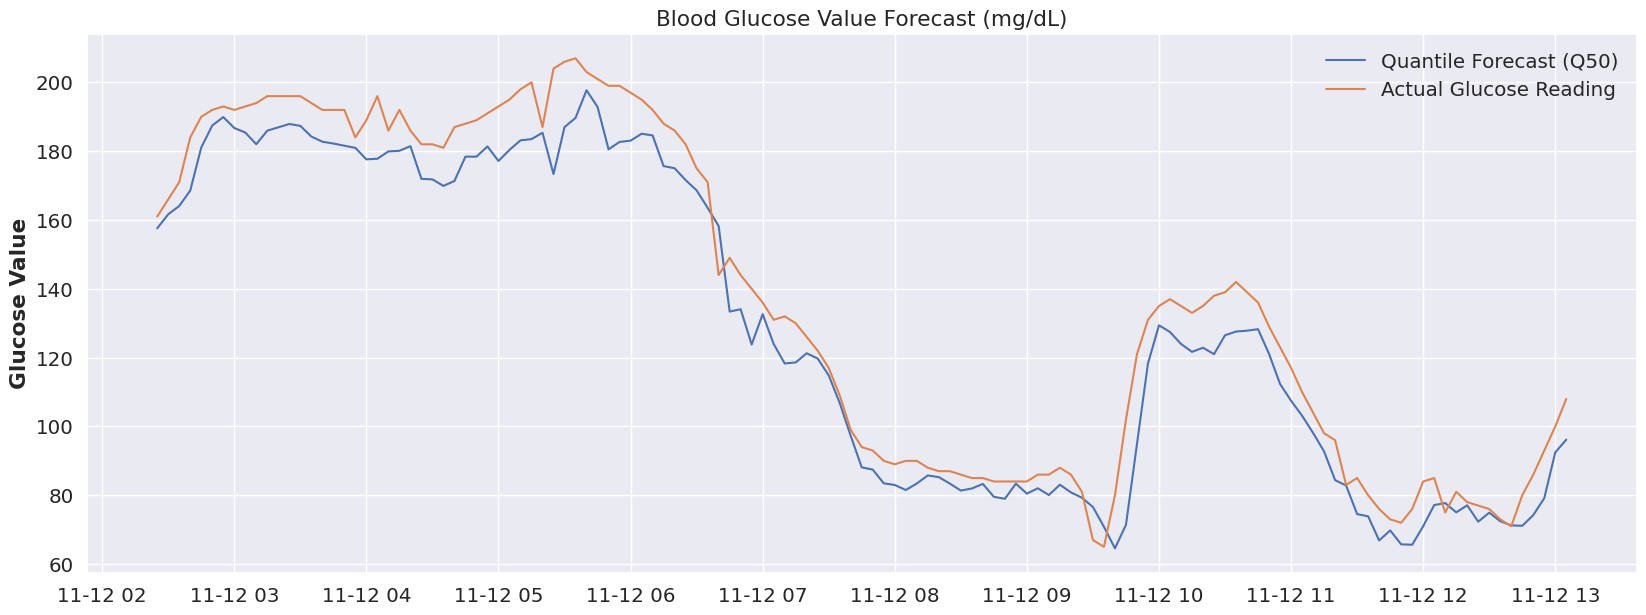

In [17]:
plot_forecast(dfY_validation, 'Q50')

What if we had a "switch" to flip (or even better, that was automatically flipped) to account for a sleeping state. Let's take a look at that same time period (prior to 7AM) at both Quantile 80.

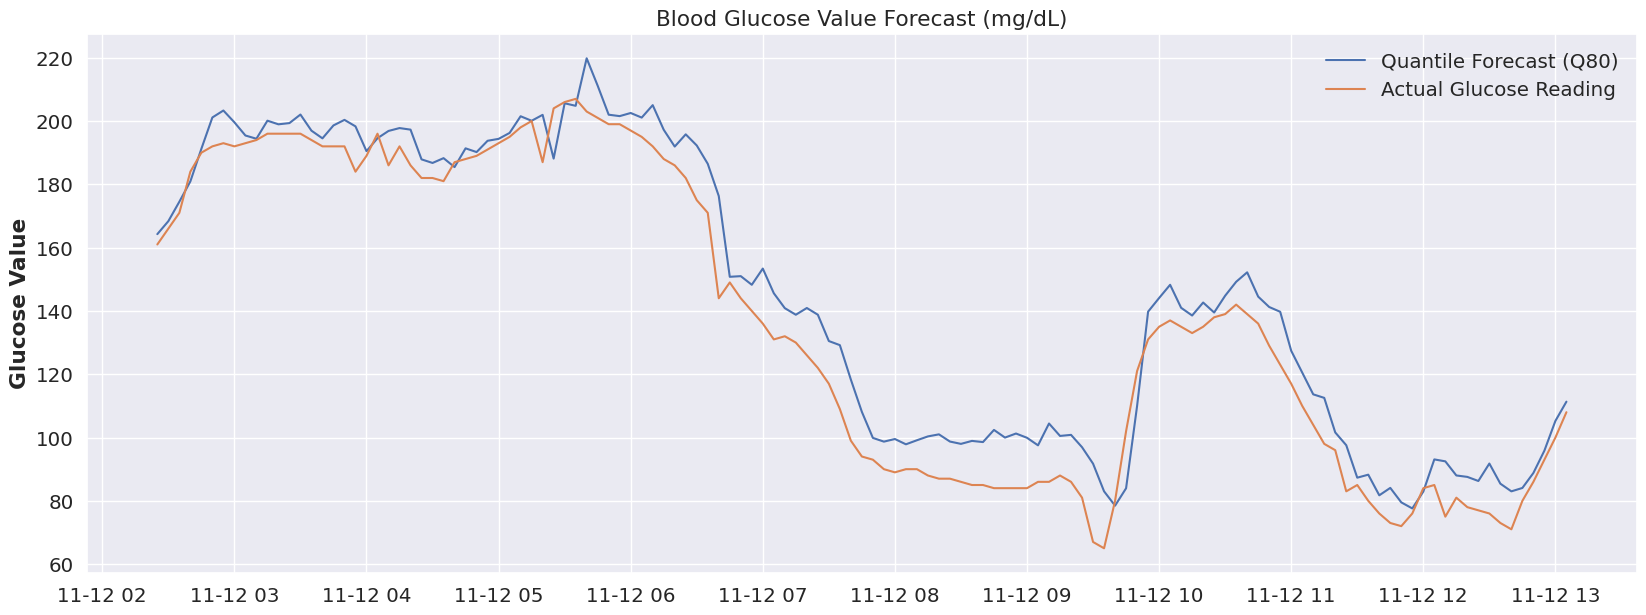

In [18]:
plot_forecast(dfY_validation, 'Q80')

Now, I didn't run the RMSE on that period (feel free to modify the code if you're interested), but visually we can tell we're much closer to reality by using the 80% quantile. If we were to associate 'sleep' with the 80% quantile, and our glucose device could flip to that quantile automatically at a pre-determine time period, then we start to see how we could use a model like this to accommodate many difference scenarios and to be extremely flexible.

But this is just our validation data, let's keep going and see what our hold out sample has in store.

## Out-of-Sample Results

In [20]:
# Run model against hold-out data

# Calculate the starting index for slicing based on the model's input chunk length
start_index_for_prediction = len(ts_ttest)  - model.input_chunk_length

# Use integer indices for slicing
input_series_for_prediction = ts_ttest[start_index_for_prediction:]

# Generate predictions
predictions = model.predict(
    n=len(ts_hold_out),
    series=input_series_for_prediction,
    past_covariates=cov_t,
    num_samples=N_SAMPLES,
    n_jobs=N_JOBS,
    verbose=False
)

We run our evaluation code on our out-of-sample data, and we start to see something interesting. Our RMSE remains very nice, but only within the 80% and 90% quantile. Previously our 50% and 80% quantiles had the best RMSE, so it's almost as if our data has shifted into a different "mode" that was more suited to our higher quantiles. Let's look at the plot of the out-of-sample data a bit more closely.

In [21]:
# Initialize variables
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
dfY_hold_out = pd.DataFrame()
dfY_hold_out["Actual"] = TimeSeries.pd_series(ts_hold_out)  # Assuming ts_test is defined

# Initialize a list to store results
quantile_results = []

# Call the helper function predQ for every quantile
_ = [predQ(predictions, q, ts_hold_out, dfY_hold_out, quantile_results) for q in QUANTILES] 

# Print the quantile results in tabular format
print(tabulate(quantile_results, headers="keys", tablefmt="psql", showindex=False))

# Move the Q50 column to the left of the Actual column
col = dfY_hold_out.pop("Q50")
dfY_hold_out.insert(1, col.name, col)

# Display a part of the DataFrame
print(tabulate(dfY_hold_out.iloc[np.r_[0:2, -2:0]], headers='keys', tablefmt='psql', showindex=True))


+------------+--------+
|   Quantile |   RMSE |
|------------+--------|
|       0.01 |  49.82 |
|       0.1  |  35.81 |
|       0.2  |  30.33 |
|       0.5  |  19.94 |
|       0.8  |  11.14 |
|       0.9  |  13.78 |
|       0.99 |  32.09 |
+------------+--------+
+---------------------+----------+---------+----------+---------+---------+---------+---------+---------+
| datetime_col        |   Actual |     Q50 |      Q01 |     Q10 |     Q20 |     Q80 |     Q90 |     Q99 |
|---------------------+----------+---------+----------+---------+---------+---------+---------+---------|
| 2023-11-12 13:10:00 |      117 | 109.799 |  86.3541 | 101.453 | 102.538 | 114.691 | 116.179 | 145.261 |
| 2023-11-12 13:15:00 |      127 | 115.314 |  92.5571 | 101.01  | 107.529 | 120.4   | 124.641 | 155.994 |
| 2023-11-12 23:50:00 |      261 | 214.325 | 175.751  | 188.549 | 196.52  | 242.239 | 259.745 | 281.487 |
| 2023-11-12 23:55:00 |      258 | 218     | 168.402  | 192.687 | 198.756 | 244.559 | 261.215 | 292.

From our 50% quantile, we see some very solid model performance during the 18:00 - 21:00 time period. Before and after that we've clearly shifted out of the distribution that was learned by Q50, so once more let's focus on our Q80 quartile and look at that plot.

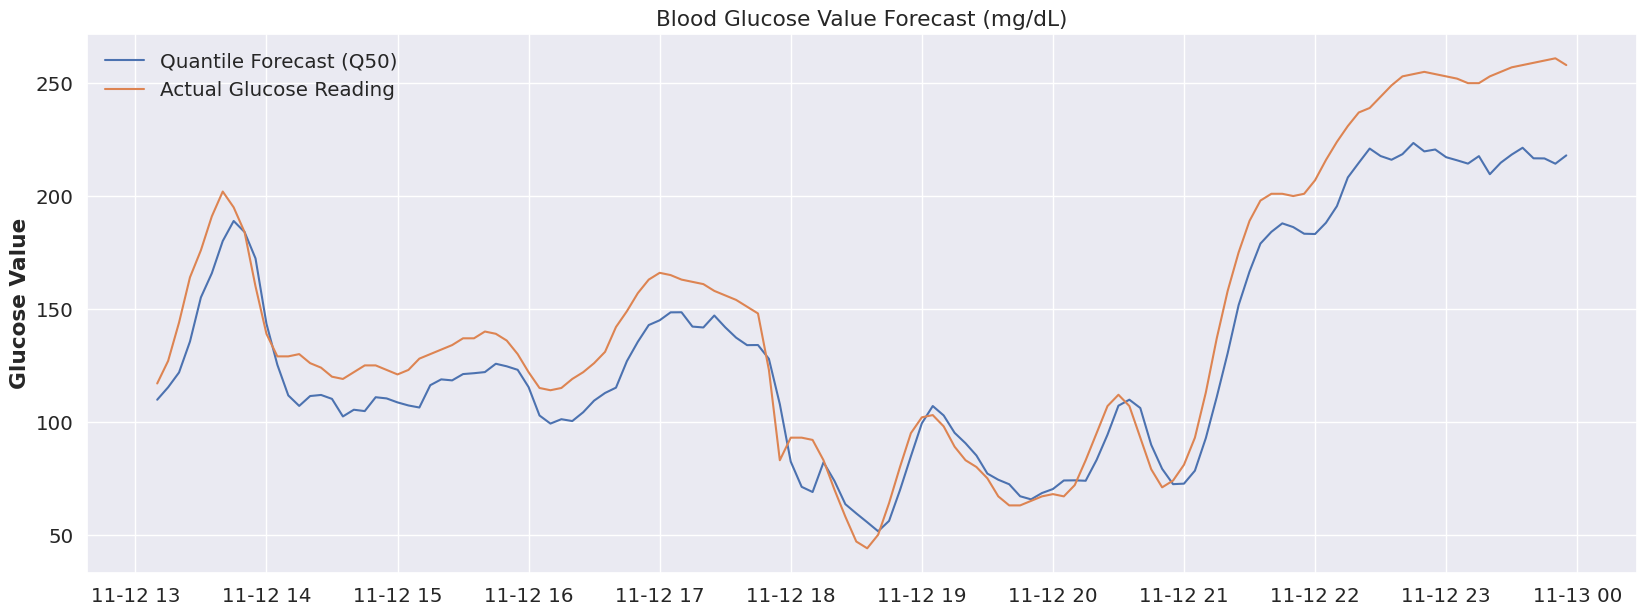

In [22]:
plot_forecast(dfY_hold_out, 'Q50')

At Q80, we're seeing much better tracking to actual data from the model's predictions. I can tell you that right around 21:00 my daughter would be drifting off to sleep, so again our "sleep = Q80" hypothesis seems to hold water there. As far as the 14:00-18:00 time period, I don't have a great explanation, but I can say that around 18:00 would've been dinner.. so it's very possible that perhaps we're seeing an overall shift of her body's glucose "system" to a Q80 during this entire range, and dinner (and related glucose impact) shifted us back to the Q50 distribution until the impact of the food wore off.

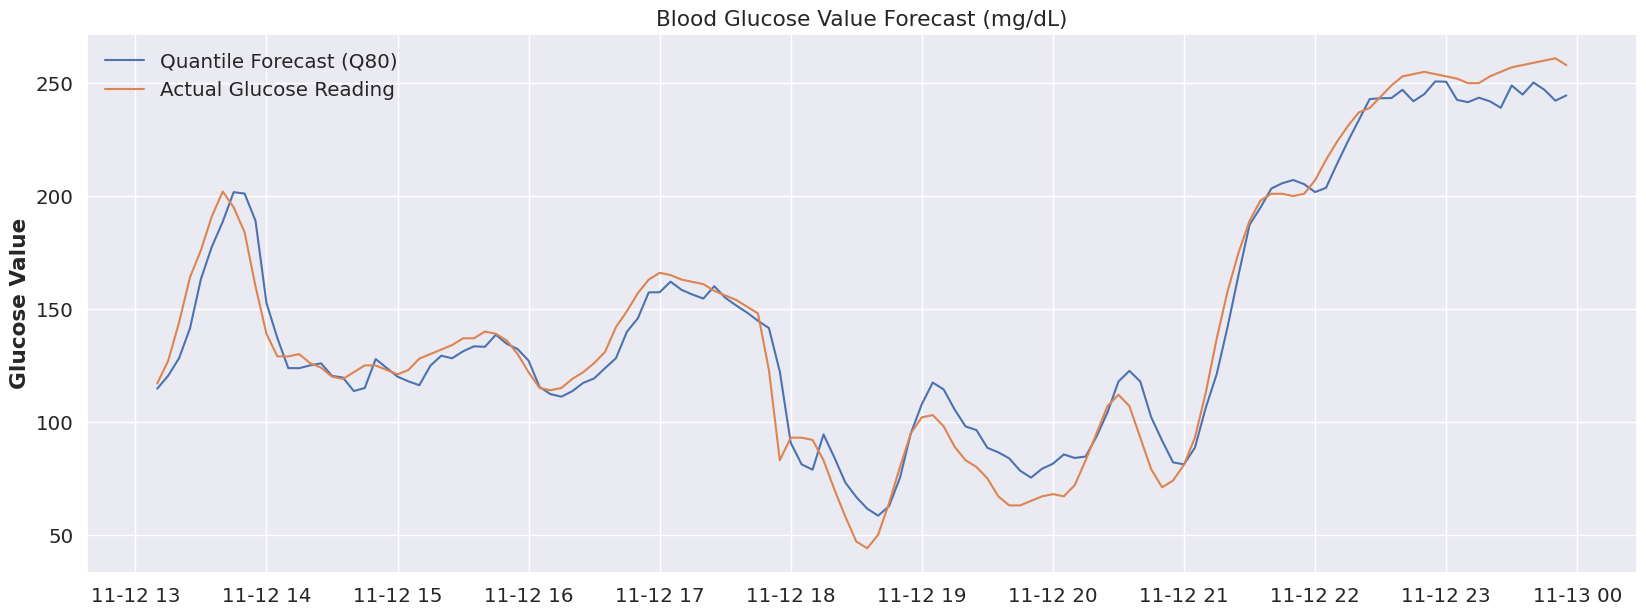

In [23]:
plot_forecast(dfY_hold_out, 'Q80')

Sadly we've reached the end of my dataset and don't have the ability to test out this hypothesis further, but in my opinion, we've pulled on a very interesting thread when it comes to forecasting glucose values. 

## Wrap-up

Historically we've seen models use categorical indicators (such as sleep, meal, etc...) to help the model understand the shifts in an individual's activities and lifestyle patterns. I think that's certainly a powerful approach, but here we're getting the idea that it may be possible to tailor a model more specifically to an individual's overall "system", and then start to associate the activities and shifts in everyday patterns to different distributions within the same model.  

The benefit to this approach is that we've now externalized the association of these patterns.. Essentially, we can build another layer of models to start to define these associations of activities and lifestyle patterns to the quantile distributions, allowing for us to adjust these associations far more easily (and frequently) than re-training a model that incorporates them inherently as features.